# 異常検知ハンズオン

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 使用データ

今回は統計解析等によく使われるRのデータセットから「Davis」というデータを使用する。

このデータセットには200人分の性別、身長(実測)、体重、身長(自己申告)の4種類のデータが用意されており、その中から体重のデータを使用する事にする。

https://vincentarelbundock.github.io/Rdatasets/datasets.html

In [4]:
current_path = current_path = os.getcwd()
df_main = pd.read_csv(current_path+"/./data/Davis.csv", index_col=0)

## 簡単なデータの確認

列名

- Sex: 性別
- weight: 体重（実測）
- height: 身長（実測）
- repwt: 体重（申告）
- repht: 身長（申告）

### データの全貌

In [6]:
# 頭20件を確認
df_main.head(20)

,sex,weight,height,repwt,repht
1,M,77,182,77.0,180.0
2,F,58,161,51.0,159.0
3,F,53,161,54.0,158.0
4,M,68,177,70.0,175.0
5,F,59,157,59.0,155.0
6,M,76,170,76.0,165.0
7,M,76,167,77.0,165.0
8,M,69,186,73.0,180.0
9,M,71,178,71.0,175.0
10,M,65,171,64.0,170.0


In [8]:
print("データの列名と型")
print(pd.DataFrame(df_main.dtypes, index=df_main.columns))
print("全データ数：", df_main.shape[0])

データの列名と型
              0
sex      object
weight    int64
height    int64
repwt   float64
repht   float64
全データ数： 200


### 基本統計量や欠損値

In [9]:
df_main.describe()

,weight,height,repwt,repht
count,200.000000,200.000000,183.000000,183.000000
mean,65.800000,170.020000,65.622951,168.497268
std,15.095009,12.007937,13.776669,9.467048
min,39.000000,57.000000,41.000000,148.000000
25%,55.000000,164.000000,55.000000,160.500000
50%,63.000000,169.500000,63.000000,168.000000
75%,74.000000,177.250000,73.500000,175.000000
max,166.000000,197.000000,124.000000,200.000000


In [145]:
# 他に気になることがあれば...


## 今回のタスク

使用するデータの内、異常値となるデータを検知する。

今回は、2.4節の「高度な特徴抽出による異常検知」を試す。

簡単なステップ（詳細は2.4節を参照）
- モデル学習
- 異常度の算出
- 異常度閾値の算出
- 結果の確認

In [12]:
X_train = df_main[["weight", "height"]]

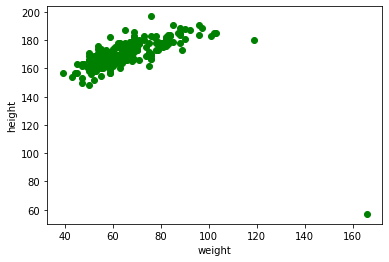

In [46]:
# データの確認（異常値の確認）
plt.plot(X_train["weight"], X_train["height"], "o", color = "g")
plt.xlabel("weight")
plt.ylabel("height")
plt.show()

### 高度な特徴抽出による異常検知（k平均法）（一例）

参考書では、EM法、主成分分析、AutoEncoder、製薬付きボルツマンマシンの紹介がされていたので、

この４つの手法のうち、どれかを選んで実装する。

In [41]:
# 使用するモデルの設定
n_clusters = 1
model = KMeans(n_clusters=n_clusters, random_state=2022)
# モデル学習
model.fit(X_train)

KMeans(n_clusters=1, random_state=2022)

In [42]:
# 異常度の算出（今回はユークリッド距離を使用）
def calc_norm(x, y):
    return np.linalg.norm(x - y)

# 必要な情報を取得
center_points = model.cluster_centers_
label_list = model.labels_

# 計算した異常度を保存する変数
anomaly_values = np.zeros(len(X_train))

# クラスターごとに異常度を計算
for label in range(n_clusters):
    ix = label_list == label
    if ix.any():
        anomaly_values[ix] = X_train.loc[ix].apply(lambda x: calc_norm(x, center_points[label]), axis=1)
    else:
        pass


In [43]:
# 異常度閾値の設定
anomaly_threshold = np.quantile(anomaly_values, q=[0.99])[0]
print(anomaly_threshold)

40.2431239893835


/var/folders/3n/yms_hk792lj3t3t4jcwhfdrc0000gn/T/ipykernel_34802/1338342569.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([0,len(X_train)],[anomaly_threshold, anomaly_threshold], 'k-', color = "r", ls = "dashed")
/var/folders/3n/yms_hk792lj3t3t4jcwhfdrc0000gn/T/ipykernel_34802/1338342569.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,len(X_train)],[anomaly_threshold, anomaly_threshold], 'k-', color = "r", ls = "dashed")


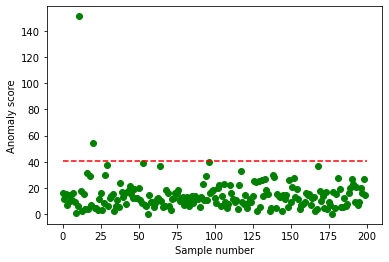

In [44]:
# 結果の描画
plt.plot(np.arange(len(X_train)), anomaly_values, "o", color = "g")
plt.plot([0,len(X_train)],[anomaly_threshold, anomaly_threshold], 'k-', color = "r", ls = "dashed")
plt.xlabel("Sample number")
plt.ylabel("Anomaly score")
plt.show()

In [45]:
# 異常値と判断されたデータを確認
df_anomaly = X_train[anomaly_values>anomaly_threshold]
df_anomaly["BMI"] = df_anomaly["weight"] / (df_anomaly["height"]/100)**2
df_anomaly

/var/folders/3n/yms_hk792lj3t3t4jcwhfdrc0000gn/T/ipykernel_34802/2122190540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomaly["BMI"] = df_anomaly["weight"] / (df_anomaly["height"]/100)**2


,weight,height,BMI
12,166,57,510.926439
21,119,180,36.728395
